In [1]:
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch import nn
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt

import utils
import utils.data, utils.ML, utils.models
from utils.models import number_of_parameters

import copy

In [127]:
device = "mps"
# device = "cpu"

# Load data

In [3]:
# various transforms:

alexnet_preprocessing = models.AlexNet_Weights.IMAGENET1K_V1.transforms()

transform_upscale = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()])

In [4]:
alexnet_preprocessing

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [5]:
batch_size = 32
num_workers = 4

train_dataloader, val_dataloader, test_dataloader = utils.data.get_CIFAR_data_loaders(batch_size, alexnet_preprocessing, num_workers)

dataloaders = [train_dataloader, val_dataloader, test_dataloader]

ImageNet_classes = utils.data.get_ImageNet_classes()

In [6]:
# Test data loading with no rescaling (for plotting):
_, _, test_dataloader_clean = utils.data.get_CIFAR_data_loaders(batch_size, transform_upscale, num_workers=0)

In [7]:
loss_fn = nn.CrossEntropyLoss()

# Run AlexNet on upsampled CIFAR images

In [6]:
# Load model:

alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

orangutan, orang, orangutang, Pongo | confidence: 39.44%
redbone                             | confidence: 7.63%
macaque                             | confidence: 3.13%
patas, hussar monkey, Erythrocebus  | confidence: 2.68%
polecat, fitch, foulmart, foumart,  | confidence: 2.52%


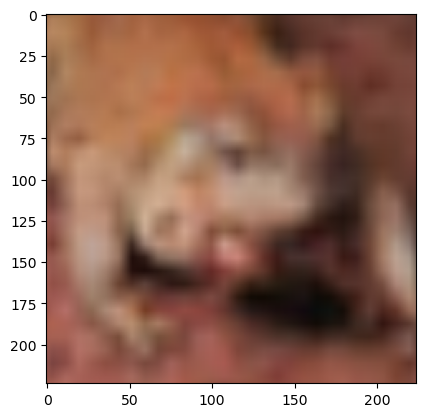

In [8]:
X, y = next(iter(test_dataloader))  # images that have be upscaled/preprocessed using AlexNet preprocessing
X_clean, _ = next(iter(test_dataloader_clean))  # for plotting

with torch.no_grad():
    out = alexnet(X)
softmax = F.softmax(out, dim=1).detach().numpy()

i = 5  # select image
    
# top-5 results:
softmax_ = softmax[i]
asort = np.argsort(softmax_)[::-1]
idxs = asort[:5]
confs = softmax_[idxs]

for pred in zip(idxs, confs):
    print(f'{ImageNet_classes[pred[0]][:35]:<35} | confidence: {pred[1]*100:.2f}%')

plt.figure()
plt.imshow(np.transpose(X_clean[i], (1, 2, 0)));

# Transfer learning with AlexNet features

In [9]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [12]:
print(X.shape)
print(alexnet.features(X).shape)
print(alexnet.avgpool(alexnet.features(X)).shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 256, 6, 6])
torch.Size([32, 256, 6, 6])


In [21]:
class finetuned_model(nn.Module):
    
    def __init__(self):
        super(finetuned_model, self).__init__()
        
        self.features = alexnet.features  # output: 256x6x6
        
        self.flatten = nn.Flatten()
        
        self.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                        nn.ReLU(),
                                        nn.Linear(1024, 10))
        
    def forward(self, x):

        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)

        return x
    

In [22]:
model = finetuned_model().to(device)

# freeze feature layer:
for param in model.features.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 5

train_loss_log, val_loss_log = utils.ML.train_model(model, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs, device, verbose=True)


 epoch:  1, training loss: 0.841, validation loss 0.591, validation accuracy 0.798
 epoch:  2, training loss: 0.513, validation loss 0.513, validation accuracy 0.826
 epoch:  3, training loss: 0.434, validation loss 0.490, validation accuracy 0.828
 epoch:  4, training loss: 0.384, validation loss 0.476, validation accuracy 0.831
 epoch:  5, training loss: 0.345, validation loss 0.472, validation accuracy 0.832

Average time per epoch: 92.531s


In [57]:
utils.ML.print_overall_metrics(model, dataloaders, loss_fn, device=device)

train loss:      0.30391, accuracy: 0.90805
validation loss: 0.47182, accuracy: 0.83170
test loss:       0.49258, accuracy: 0.82860


# Transfer learning with ResNet18 features

In [48]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

In [24]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
# input dimension of classifier:
print(resnet18.fc.in_features)

512


In [49]:
# freeze parameters:
for param in resnet18.parameters():
    param.requires_grad = False

# Modify classifier to output 10 classes (requires_grad = True by default):
# resnet18.fc = nn.Linear(512, 10)
resnet18.fc = nn.Sequential(nn.Linear(512, 256),
                           nn.ReLU(),
                           nn.Linear(256, 10))

resnet18 = resnet18.to(device)

In [51]:
optimizer = torch.optim.Adam(resnet18.parameters(), lr=1e-3)

num_epochs = 5

train_loss_log, val_loss_log = utils.ML.train_model(resnet18, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs, device, verbose=True)


 epoch:  1, training loss: 0.766, validation loss 0.648, validation accuracy 0.773
 epoch:  2, training loss: 0.712, validation loss 0.703, validation accuracy 0.751
 epoch:  3, training loss: 0.677, validation loss 0.654, validation accuracy 0.769
 epoch:  4, training loss: 0.656, validation loss 0.617, validation accuracy 0.786
 epoch:  5, training loss: 0.625, validation loss 0.624, validation accuracy 0.784

Average time per epoch: 139.814s


In [58]:
utils.ML.print_overall_metrics(resnet18, dataloaders, loss_fn, device=device)

train loss:      0.53028, accuracy: 0.81340
validation loss: 0.62364, accuracy: 0.78430
test loss:       0.64241, accuracy: 0.78140


# Inception

In [106]:
inception = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

inception_preprocessing = models.Inception_V3_Weights.IMAGENET1K_V1.transforms()

In [111]:
# Re-create data loaders with inception pre-processing

inception_train_dataloader, inception_val_dataloader, inception_test_dataloader = utils.data.get_CIFAR_data_loaders(128, inception_preprocessing, num_workers)
inception_dataloaders = [inception_train_dataloader, inception_val_dataloader, inception_test_dataloader]

In [9]:
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [108]:
for param in inception.parameters():
    param.requires_grad = False
    
inception.fc = nn.Sequential(nn.Linear(2048, 512),
                            nn.ReLU(),
                            nn.Linear(512, 10))

inception = inception.to(device)

In [11]:
optimizer = torch.optim.Adam(inception.parameters(), lr=1e-3)

num_epochs = 5

train_loss_log, val_loss_log = utils.ML.train_inception(inception, inception_train_dataloader, inception_val_dataloader, optimizer, loss_fn, num_epochs, device, verbose=True)


 epoch:  1, training loss: 1.136, validation loss 0.839, validation accuracy 0.706
 epoch:  2, training loss: 1.006, validation loss 0.811, validation accuracy 0.717
 epoch:  3, training loss: 0.972, validation loss 0.832, validation accuracy 0.705
 epoch:  4, training loss: 0.962, validation loss 0.817, validation accuracy 0.718
 epoch:  5, training loss: 0.944, validation loss 0.762, validation accuracy 0.732

Average time per epoch: 435.056s


# Test: learn upsampling?

In [16]:
device = "mps"

 epoch:  1, training loss: 1.181, validation loss 1.042, validation accuracy 0.632
 epoch:  2, training loss: 0.880, validation loss 0.968, validation accuracy 0.669
 epoch:  3, training loss: 0.714, validation loss 0.980, validation accuracy 0.667
 epoch:  4, training loss: 0.573, validation loss 0.964, validation accuracy 0.681
 epoch:  5, training loss: 0.441, validation loss 1.005, validation accuracy 0.684

Average time per epoch: 157.053s


In [35]:
for param in model.upsampling.parameters():
    print(param)

Parameter containing:
tensor([[[[1.0272, 0.9574],
          [0.9506, 1.0218]],

         [[1.0272, 0.9574],
          [0.9506, 1.0218]],

         [[1.0272, 0.9574],
          [0.9506, 1.0218]]],


        [[[1.0159, 0.9871],
          [0.9649, 1.0086]],

         [[1.0159, 0.9871],
          [0.9649, 1.0086]],

         [[1.0159, 0.9871],
          [0.9649, 1.0086]]],


        [[[0.9795, 0.9808],
          [1.0229, 1.0016]],

         [[0.9795, 0.9808],
          [1.0229, 1.0016]],

         [[0.9795, 0.9808],
          [1.0229, 1.0016]]]], device='mps:0', requires_grad=True)
Parameter containing:
tensor([[[[1.0195, 0.9485],
          [0.9527, 1.0234]],

         [[1.0195, 0.9485],
          [0.9527, 1.0234]],

         [[1.0195, 0.9485],
          [0.9527, 1.0234]]],


        [[[1.0195, 0.9485],
          [0.9527, 1.0234]],

         [[1.0195, 0.9485],
          [0.9527, 1.0234]],

         [[1.0195, 0.9485],
          [0.9527, 1.0234]]],


        [[[1.0195, 0.9485],
          [0.

torch.Size([32, 3, 256, 256])


tensor(-28.6709) tensor(25.2090)
tensor(0.) tensor(1.)


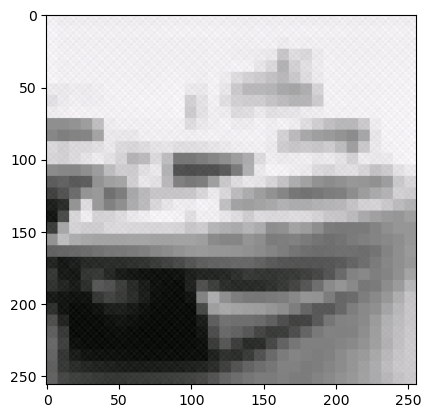